# Evaluate Saved DGA Model

This notebook loads a saved Keras model, draws a confusion matrix, and predicts domains from a text file.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

2025-12-29 20:15:13.802018: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/data/venv/lib/python3.13/site-packages/keras/src/export/tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


In [2]:
# Load saved model
model = load_model("dga_detection_model_local.keras")
model.summary()

I0000 00:00:1767035718.369072    5847 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4390 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1660 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (64, 75, 128)          │         9,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ (64, 75, 128)          │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (64, 100)              │        91,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (64, 1)                │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 302,369 (1.15 MB)

 Trainable params: 100,789 (393.71 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 201,580 (787.43 KB)

## Predict sample domains

In [3]:
import pandas as pd
#import numpy as np
#from tensorflow.keras.models import Sequential
#from tensorflow.keras.layers import LSTM, Dense, Embedding, SpatialDropout1D
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
#from sklearn.preprocessing import LabelEncoder

# Load the dataset
df = pd.read_csv('dataset.csv')

In [4]:
# Tokenization: Convert each domain into a list of characters (or n-grams if you prefer)
def domain_to_chars(domain):
    return list(domain)

df['domain_chars'] = df['domain'].apply(domain_to_chars)

In [5]:
# Create a character-to-integer mapping
chars = set(''.join(df['domain']))  # Set of all characters
char_to_int = {char: idx+1 for idx, char in enumerate(sorted(chars))}  # +1 because index 0 will be reserved for padding

# Apply encoding to the domains
df['domain_int'] = df['domain_chars'].apply(lambda x: [char_to_int[char] for char in x])

In [6]:
# Pad the sequences to a fixed length (e.g., 50 characters)
MAX_LENGTH = 75  # Adjust based on the length of your longest domain name
X = pad_sequences(df['domain_int'], maxlen=MAX_LENGTH)

# Labels
y = df['label'].values

In [7]:
# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

3750/3750 ━━━━━━━━━━━━━━━━━━━━ 222s 59ms/step


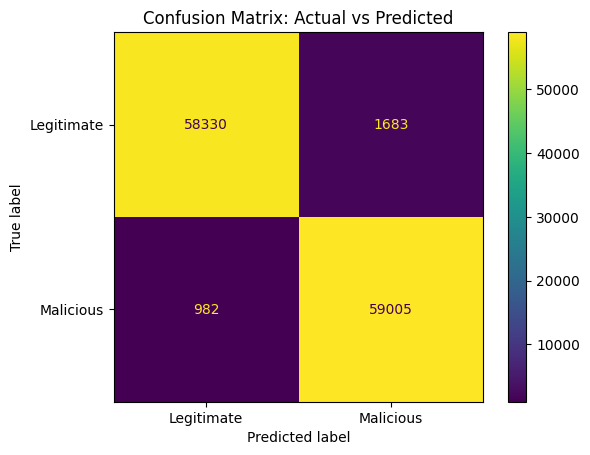

In [8]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Get predicted probabilities on the test set
y_pred_prob = model.predict(X_test)

# Convert probabilities to binary labels (0 = Legitimate, 1 = Malicious)
y_pred = (y_pred_prob > 0.5).astype(int).ravel()

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display confusion matrix
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["Legitimate", "Malicious"]
)
disp.plot()
plt.title("Confusion Matrix: Actual vs Predicted")
plt.show()

In [9]:
with open("test_sample.txt") as f:
    sample_domains = [line.strip() for line in f if line.strip()]

X_sample = preprocess_domains(sample_domains)
probs = model.predict(X_sample).ravel()

for domain, prob in zip(sample_domains, probs):
    label = "Malicious" if prob > 0.5 else "Legitimate"
    print(f"{domain:35s} -> {label} (confidence: {prob:.3f})")

NameError: name 'preprocess_domains' is not defined